# Non-duplicated Selection Analysis (RQ1, RQ2)

This notebooks analyzes the non-duplicated notebook selection. These analyses answer RQ1 and RQ2.

In [1]:
import sys
sys.path.insert(0, '../archaeology')

import re

from collections import Counter
from string import ascii_letters, digits

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import analysis_helpers, importlib
importlib.reload(analysis_helpers)

from analysis_helpers import var, relative_var, count, savefig, fig
from analysis_helpers import display_counts, cell_distribution
from analysis_helpers import distribution_with_boxplot
from analysis_helpers import boxplot_distribution, counter_hist
from analysis_helpers import dbmt, DBMT, print_relative_var_group
from analysis_helpers import load_vars, group_run, dbmt_relative_var
from analysis_helpers import dbmt_prepare_selectors
from db import connect


%matplotlib inline

## Query

Select notebooks and markdowns from:

- existing

  ```n.skip & 2048 = 0```

- valid
  
  ```NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
     AND n.processed & 15 = 0 AND n.skip & (1024 + 512) = 0
  ```


- non-duplicated notebooks
  
  ```n.skip & (1024 + 512 + 128) = 0```

In [2]:
%%time
with connect() as session:
    print('Query Notebooks')
    notebooks = pd.read_sql("""
        SELECT n.*, n.id as notebook_id
        FROM notebooks n
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
    """, session.connection())
    print("Non duplicated notebooks:", len(notebooks))
    

Query Notebooks
Non duplicated notebooks: 1024269
CPU times: user 14.7 s, sys: 2.21 s, total: 17 s
Wall time: 17.9 s


In [3]:
with connect() as session:
    print('Query Repositories')
    t_repositories = pd.read_sql("""
        SELECT r.*, u.stargazers, u.forks
        FROM repositories r
        LEFT JOIN repository_updates u ON (r.id = u.repository_id)
    """, session.connection())

Query Repositories


In [4]:
with connect() as session:
    print('Query Markdowns')
    markdowns = pd.read_sql("""
        SELECT m.*, n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebook_markdowns m
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND m.cell_count > 0
        AND m.notebook_id = n.id
    """, session.connection())
    dbmt_relative_var(
        "Notebooks with markdown: {}", "a2_notebooks_with_markdown",
        dbmt(markdowns), dbmt(notebooks)
    )

Query Markdowns
Notebooks with markdown: a2_notebooks_with_markdown


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"708,393 (69.16%)",None,None,None,None,None
1,(Sample),sd_,47 (68.12%),0.01%,0.00%,98.49%,(-) 1.51%,-1.04%
2,(Popular),td_,"33,319 (87.54%)",4.70%,3.25%,126.57%,(+) 26.57%,18.38%


In [5]:
BINS = 1261
cell_type_bins_arrays = {
    key: {
        'code': np.zeros(BINS),
        'heading': np.zeros(BINS),
        'markdown': np.zeros(BINS),
        'raw': np.zeros(BINS),
    } for key, _ in DBMT + [(None, '<deleted>')]
}

with connect() as session:
    print('Query Bins') 
    bin_arrays = session.execute("""
        SELECT n.id as notebook_id, m.bins_code, m.bins_markdown, 
        m.bins_heading, m.bins_raw, n.stargazers, n.forks, n.starforks
        FROM notebooks n, notebooks_meta_aggregates m
        WHERE NOT (n.kernel = 'no-kernel' AND n.nbformat = '0')
        AND n.processed & 15 = 0
        AND n.skip & 2048 = 0
        AND n.skip & (1024 + 512) = 0
        AND n.skip & (1024 + 512 + 128) = 0
        AND m.notebook_id = n.id
    """)
    get_selectors = dbmt_prepare_selectors()
    for row in bin_arrays:
        selectors = get_selectors(row)
        if len(row.bins_code) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['code'] += np.array(row.bins_code)
        if len(row.bins_markdown) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['markdown'] += np.array(row.bins_markdown)
        if len(row.bins_heading) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['heading'] += np.array(row.bins_heading)
        if len(row.bins_raw) > 1:
            for selector in selectors:
                cell_type_bins_arrays[selector]['raw'] += np.array(row.bins_raw)


Query Bins


In [6]:
repositories_10_or_more = t_repositories[
    t_repositories["notebooks_count"] >= 10
]
repositories_10_or_more_ids = set(repositories_10_or_more["id"].tolist())

## Cell types

### Distribution

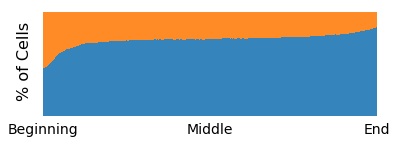

(Sample) 


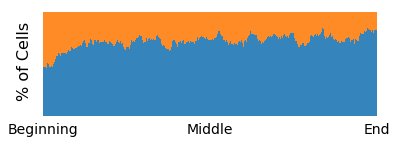

(Popular) 


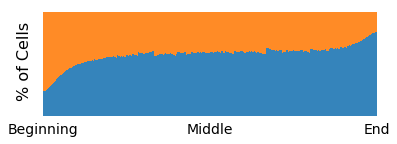

In [7]:
select = ["code", "markdown"] #, "raw", "heading"]

def celltype_distribution(arrays, prefix):
    with cell_distribution(prefix + "a2_celltype_distribution", 6, 2, select, BINS - 1, arrays) as ax:
        pass
        #ax.annotate("markdown", xy=(30, 80), color="white", weight="bold")
        #ax.annotate("code", xy=(1100, 20), color="white", weight="bold")
        
group_run([cell_type_bins_arrays[prefix] for prefix, _ in DBMT], DBMT, celltype_distribution);


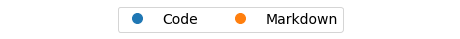

In [8]:


with savefig("a2_celltype_distribution_legend", 8, 0.3):
    texts = ["Code", "Markdown"]
    colors = ["tab:blue", "tab:orange"]
    patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
                label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, 0.5), 
               loc='center', ncol=3, numpoints=1 )
    ax = plt.gca()
    ax.axis("off")


### Code


Distribution(min=0, q1=7.0, median=13.0, q3=24.0, max=932)
50% of the notebooks have 13 code cells or less


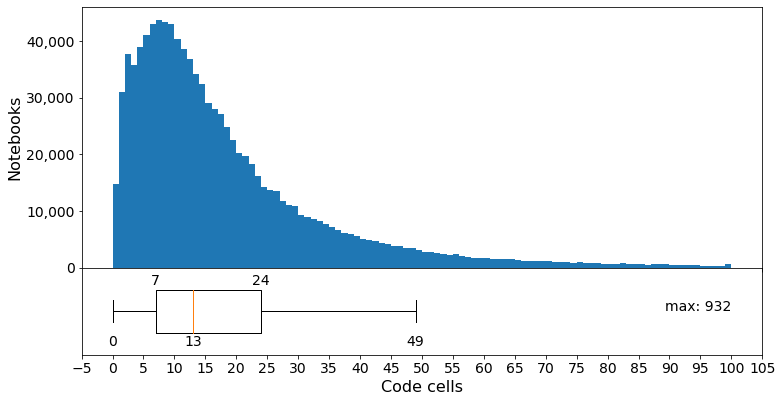

(Sample) 
Distribution(min=0, q1=7.0, median=18.0, q3=27.0, max=292)
50% of the notebooks have 18 code cells or less


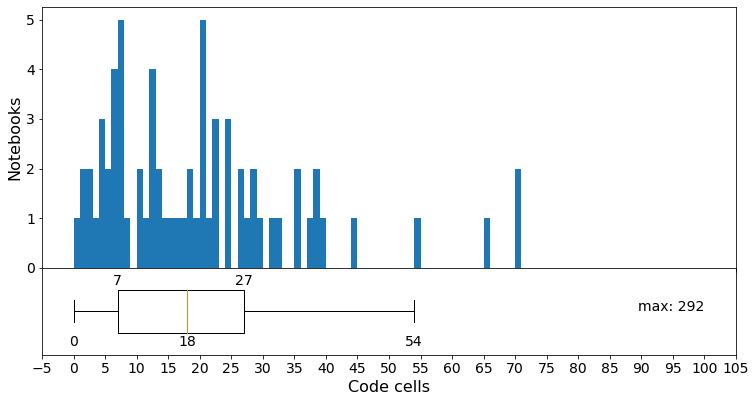

(Popular) 
Distribution(min=0, q1=6.0, median=11.0, q3=20.0, max=602)
50% of the notebooks have 11 code cells or less


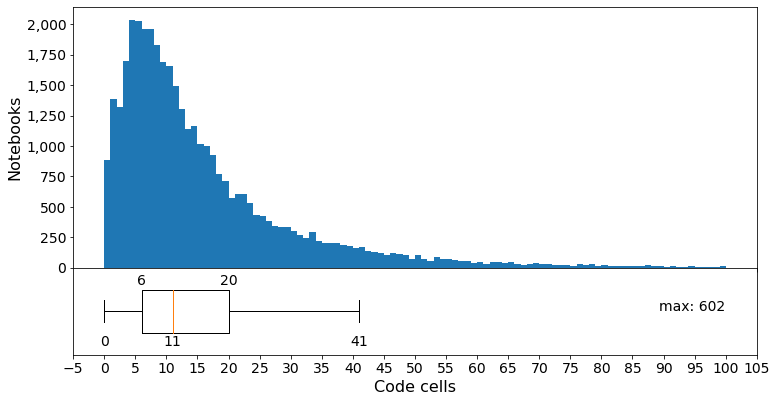

In [9]:
def notebook_code_cells(notebooks, prefix):
    with fig(prefix + "a2_notebook_code_cells", 10, 6):
        column = notebooks["code_cells"]
        distribution = distribution_with_boxplot(column, 0, 100, 5, "Notebooks", "Code cells",  True)
        print(distribution)
        print("50% of the notebooks have {} code cells or less".format(
            var(prefix + "a2_code_cells_median", int(distribution.median), "{:g}")
        ))

        
group_run(dbmt(notebooks), DBMT, notebook_code_cells);

### Markdown

In [10]:
dfs = zip(dbmt(notebooks), dbmt(markdowns))
dbmt_relative_var(
    "Notebooks without markdown: {}", "a2_no_markdown_cells",
    dfs, dbmt(notebooks),
    fn=lambda x: len(x[0]) - len(x[1])
)

Notebooks without markdown: a2_no_markdown_cells


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"315,876 (30.84%)",None,None,None,None,None
1,(Sample),sd_,22 (31.88%),0.01%,0.00%,103.39%,(+) 3.39%,1.04%
2,(Popular),td_,"4,744 (12.46%)",1.50%,0.46%,40.41%,(-) 59.59%,-18.38%



Distribution(min=0, q1=0.0, median=4.0, q3=12.0, max=754)
50% of the notebooks have 4 markdown cells or less


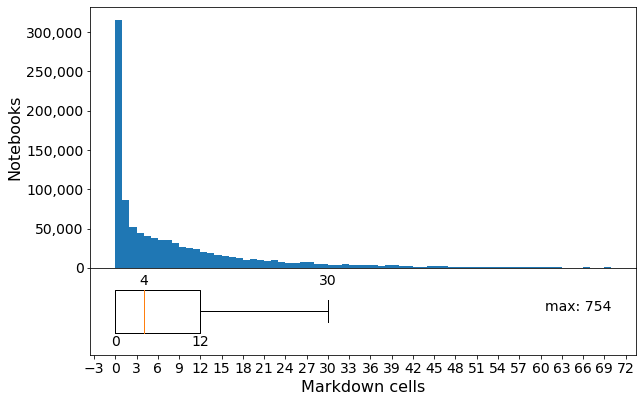

(Sample) 
Distribution(min=0, q1=0.0, median=5.0, q3=13.0, max=62)
50% of the notebooks have 5 markdown cells or less


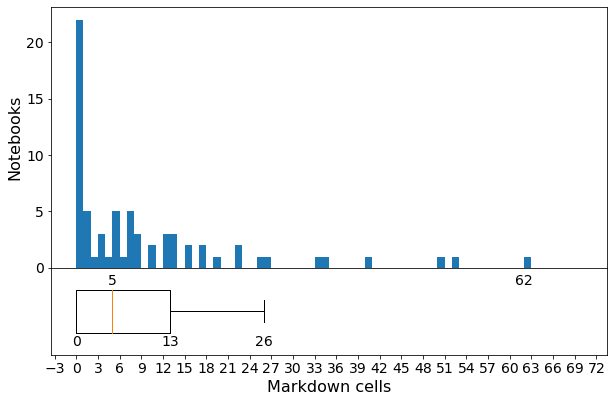

(Popular) 
Distribution(min=0, q1=3.0, median=8.0, q3=16.0, max=259)
50% of the notebooks have 8 markdown cells or less


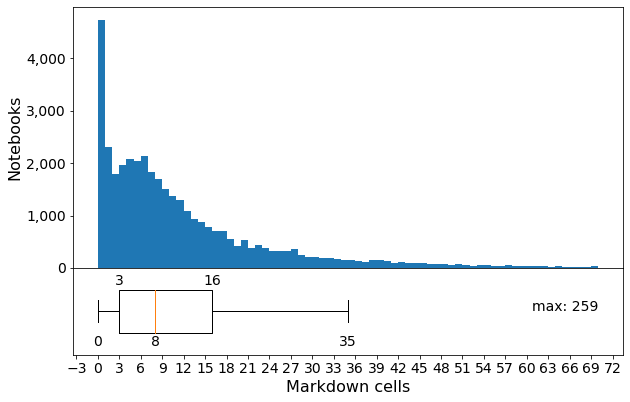

In [11]:
def notebook_markdown_cells(notebooks, prefix):
    with fig(prefix + "a2_notebook_markdown_cells"):
        column = notebooks["markdown_cells"]
        distribution = distribution_with_boxplot(column, 0, 70, 3, "Notebooks", "Markdown cells",  True)
        print(distribution)
        print("50% of the notebooks have {} markdown cells or less".format(
            var(prefix + "a2_markdown_cells_median", int(distribution.median), "{:g}")
        ))

group_run(dbmt(notebooks), DBMT, notebook_markdown_cells);

#### Lines


Distribution(min=0, q1=10.0, median=26.0, q3=65.0, max=16575)
Markdown lines median: 26


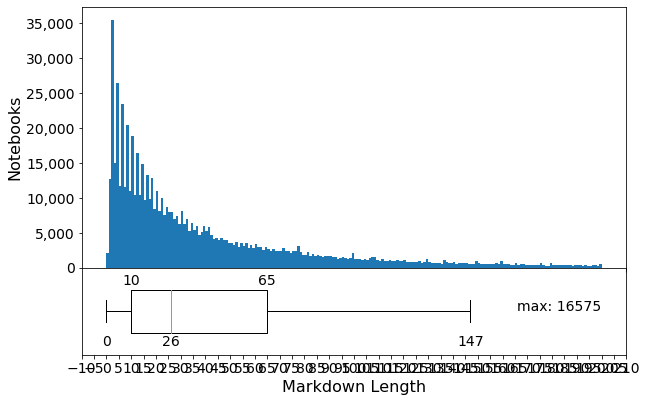

(Sample) 
Distribution(min=2, q1=12.0, median=24.0, q3=60.5, max=709)
Markdown lines median: 24


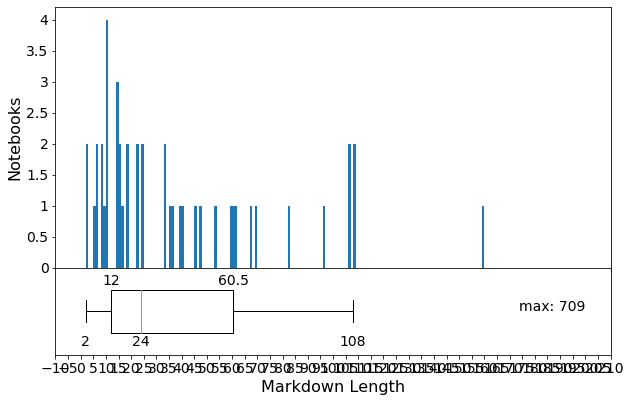

(Popular) 
Distribution(min=0, q1=12.0, median=25.0, q3=60.0, max=12260)
Markdown lines median: 25


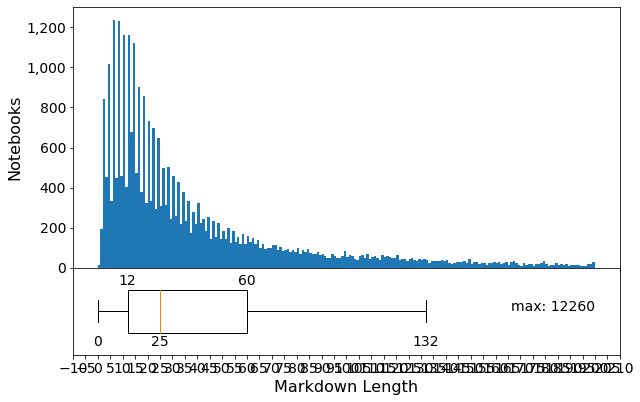

In [12]:
def markdown_meaningful_lines(markdowns, prefix):
    with fig(prefix + "a2_markdown_meaningful_lines"):
        column = markdowns["meaningful_lines"]
        distribution = distribution_with_boxplot(column, 0, 200, 5, "Notebooks", "Markdown Length",  True)
        print(distribution)
        print("Markdown lines median:", var(
            prefix + "a2_markdown_lines_median", int(distribution.median)
        ))
        

group_run(dbmt(markdowns), DBMT, markdown_meaningful_lines);


Distribution(min=0, q1=34.0, median=168.0, q3=629.0, max=108551)
Markdown words median: 168


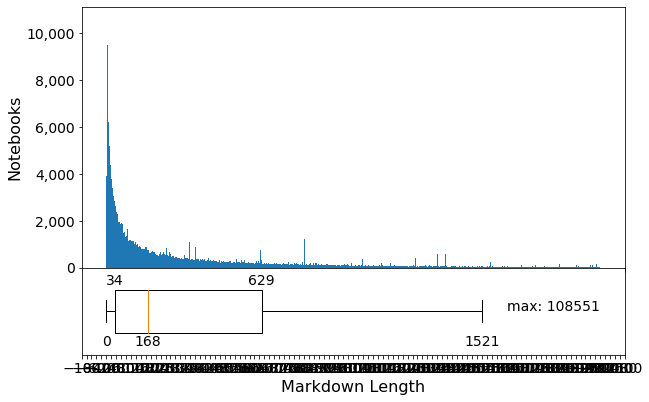

(Sample) 
Distribution(min=1, q1=31.0, median=252.0, q3=775.0, max=10270)
Markdown words median: 252


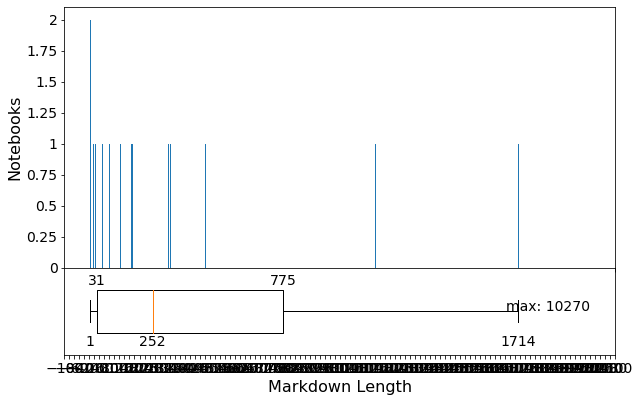

(Popular) 
Distribution(min=0, q1=34.0, median=118.0, q3=564.0, max=15093)
Markdown words median: 118


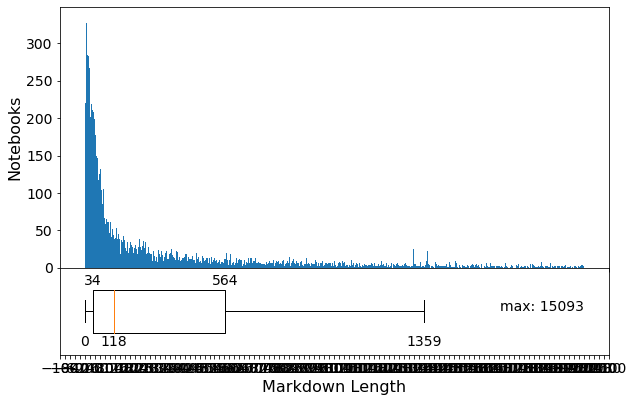

In [13]:
def markdown_meaninful_words(markdowns, prefix):
    with fig(prefix + "a2_markdown_meaningful_words"):
        column = markdowns["meaningful_words"]
        distribution = distribution_with_boxplot(column, 0, 2000, 20, "Notebooks", "Markdown Length",  True)
        print(distribution)
        print("Markdown words median:", var(
            prefix + "a2_markdown_words_median", int(distribution.median)
        ))
        

group_run(dbmt(markdowns), DBMT, markdown_meaninful_words);


Distribution(min=0, q1=4.0, median=44.0, q3=208.0, max=57813)
Markdown stopwords median: 44


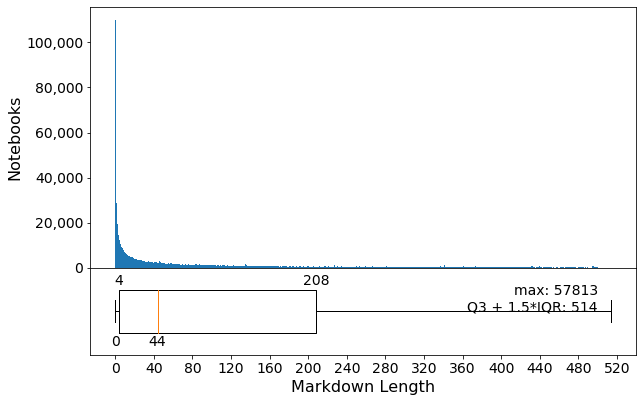

(Sample) 
Distribution(min=0, q1=7.0, median=84.0, q3=306.0, max=3583)
Markdown stopwords median: 84


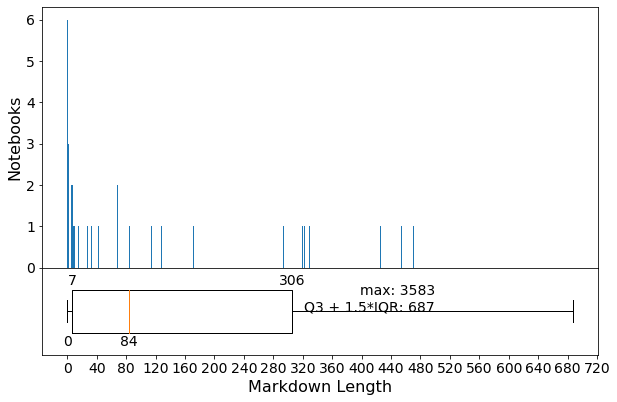

(Popular) 
Distribution(min=0, q1=1.0, median=23.0, q3=183.0, max=6060)
Markdown stopwords median: 23


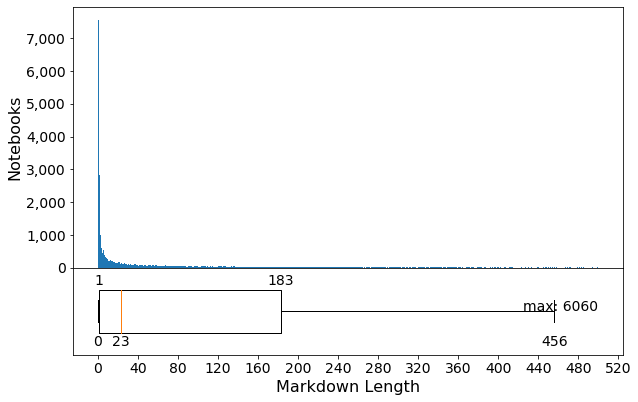

In [14]:
def markdown_meaningful_stopwords(markdowns, prefix):
    with fig(prefix + "a2_markdown_meaningful_stopwords"):
        column = markdowns["meaningful_stopwords"]
        distribution = distribution_with_boxplot(column, 0, 500, 40, "Notebooks", "Markdown Length",  True)
        print(distribution)
        print("Markdown stopwords median:", var(
            prefix + "a2_markdown_stopwords_median", int(distribution.median)
        ))
    
group_run(dbmt(markdowns), DBMT, markdown_meaningful_stopwords);

#### Languages

,0
english,619001
undetected,268314
french,89408
italian,88661
german,69111
romanian,51645
indonesian,50286
spanish,39980
norwegian,35670
portuguese,31956


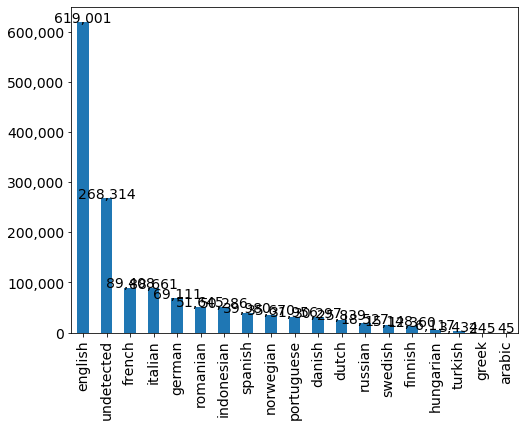

(Sample) 


,0
english,44
undetected,14
french,11
portuguese,6
romanian,6
german,5
italian,5
norwegian,4
indonesian,4
finnish,2


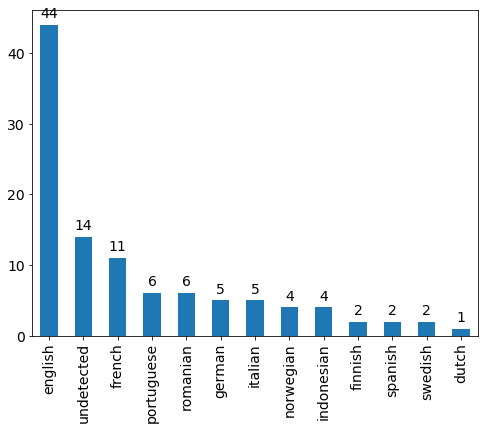

(Popular) 


,0
english,30454
undetected,11865
french,6551
italian,3517
german,2770
romanian,2531
portuguese,2412
indonesian,1953
norwegian,1624
spanish,1352


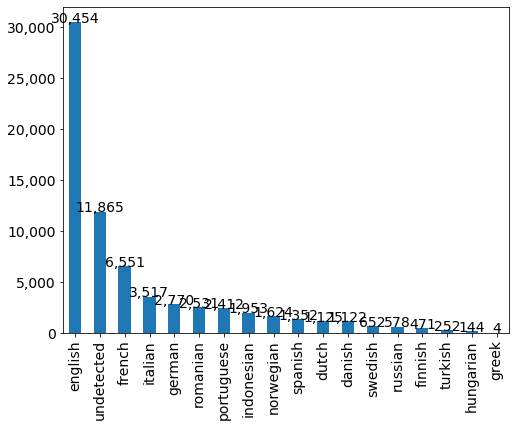

In [15]:
def markdown_languages(markdowns, prefix):
    with fig(prefix + "a2_markdown_languages"):
        counter = Counter()
        markdowns["languages"].agg(lambda x: counter.update({
            y for y in x.split(",")
            if y
        }))
        del counter['']
        counts = pd.Series(counter).sort_values(ascending=False)
        _, cnt = display_counts(
            counts, width=20, show_values=True, plot=False,
            cut=slice(None, 20), logy=False
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)
        
group_run(dbmt(markdowns), DBMT, markdown_languages);

In [16]:
dbmt_relative_var(
    "Notebooks that only use english: {}", "a2_notebooks_with_english_only_markdown",
    dbmt(markdowns[markdowns["languages"] == "english"]),
    dbmt(markdowns),
)

Notebooks that only use english: a2_notebooks_with_english_only_markdown


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"275,380 (38.87%)",None,None,None,None,None
1,(Sample),sd_,18 (38.30%),0.01%,0.00%,98.52%,(-) 1.48%,-0.58%
2,(Popular),td_,"11,571 (34.73%)",4.20%,1.63%,89.33%,(-) 10.67%,-4.15%


,0
english,619001
other,327908
undetected,268314


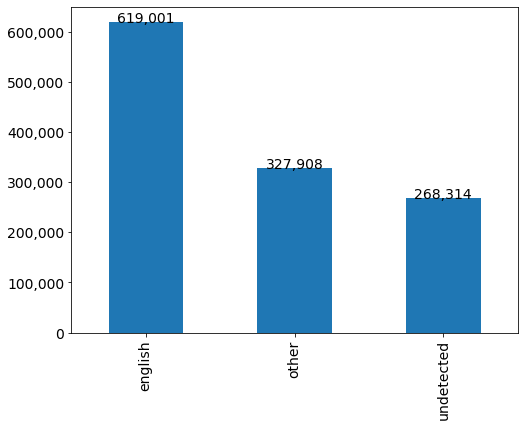

(Sample) 


,0
english,44
other,25
undetected,14


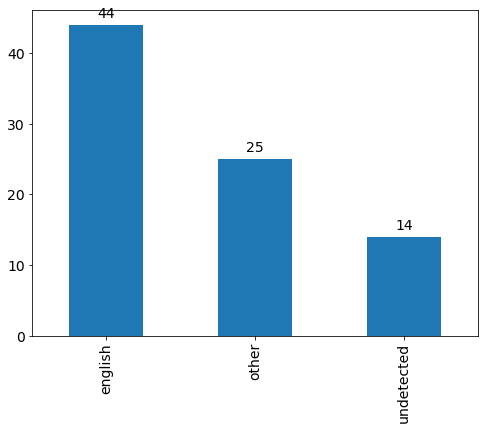

(Popular) 


,0
english,30454
other,16684
undetected,11865


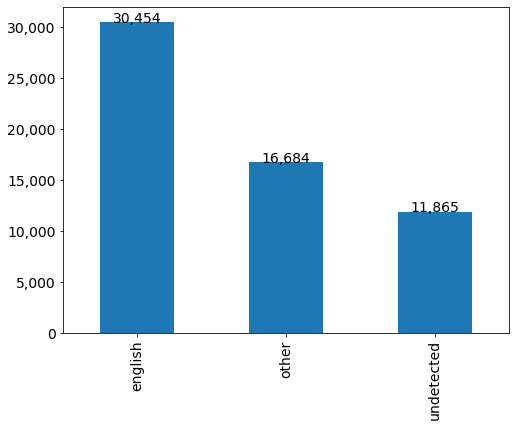

In [17]:
def markdown_language_categories(markdowns, prefix):
    with fig(prefix + "a2_markdown_language_categories"):
        counter = Counter()
        markdowns["languages"].agg(lambda x: counter.update({
            (y if y in ("english", "undetected") else "other") for y in x.split(",")
            if y
        }))
        del counter['']
        counts = pd.Series(counter).sort_values(ascending=False)
        _, cnt = display_counts(
            counts, width=20, show_values=True, plot=False,
            cut=slice(None, 10), logy=False
        )
        display(cnt)
        ax = plt.gca()
        ax.legend().set_visible(False)
    return cnt
cnts = group_run(dbmt(markdowns), DBMT, markdown_language_categories);

In [18]:
dbmt_relative_var(
    "Notebooks with english markdown: {}", "a2_notebooks_with_english_markdown",
    cnts, dbmt(markdowns), 
    fn=lambda cnt: cnt.loc["english", 0]
)
dbmt_relative_var(
    "Notebooks with other languages: {}", "a2_notebooks_with_other_markdown",
    cnts, dbmt(markdowns), 
    fn=lambda cnt: cnt.loc["other", 0]
)
dbmt_relative_var(
    "Notebooks with undetected languages: {}", "a2_notebooks_with_undetected_markdown",
    cnts, dbmt(markdowns), 
    fn=lambda cnt: cnt.loc["undetected", 0]
)

Notebooks with english markdown: a2_notebooks_with_english_markdown


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"619,001 (87.38%)",None,None,None,None,None
1,(Sample),sd_,44 (93.62%),0.01%,0.01%,107.14%,(+) 7.14%,6.24%
2,(Popular),td_,"30,454 (91.40%)",4.92%,4.30%,104.60%,(+) 4.60%,4.02%


Notebooks with other languages: a2_notebooks_with_other_markdown


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"327,908 (46.29%)",None,None,None,None,None
1,(Sample),sd_,25 (53.19%),0.01%,0.00%,114.91%,(+) 14.91%,6.90%
2,(Popular),td_,"16,684 (50.07%)",5.09%,2.36%,108.18%,(+) 8.18%,3.78%


Notebooks with undetected languages: a2_notebooks_with_undetected_markdown


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"268,314 (37.88%)",None,None,None,None,None
1,(Sample),sd_,14 (29.79%),0.01%,0.00%,78.64%,(-) 21.36%,-8.09%
2,(Popular),td_,"11,865 (35.61%)",4.42%,1.67%,94.02%,(-) 5.98%,-2.27%


#### Elements

In [19]:
counters = [count(
    markdown,
    "header",
    "h1", "h2", "h3", "h4", "h5", "h6",
    "hrule", "list", "table", "p", "quote",
    "code", "image", "link", "autolink",
    "codespan", "emphasis", "double_emphasis",
    "strikethrough", "html", "math", "block_math", "latex"
) for markdown in dbmt(markdowns)]

dbmt_relative_var(
    "Notebooks with header: {}", "a2_markdown_header_notebooks",
    counters, dbmt(markdowns), 
    fn=lambda x: x["header"]
)
dbmt_relative_var(
    "Notebooks with p: {}", "a2_markdown_p_notebooks",
    counters, dbmt(markdowns), 
    fn=lambda x: x["p"]
)


Notebooks with header: a2_markdown_header_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"642,673 (90.72%)",None,None,None,None,None
1,(Sample),sd_,44 (93.62%),0.01%,0.01%,103.19%,(+) 3.19%,2.89%
2,(Popular),td_,"31,816 (95.49%)",4.95%,4.49%,105.25%,(+) 5.25%,4.77%


Notebooks with p: a2_markdown_p_notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"563,146 (79.50%)",None,None,None,None,None
1,(Sample),sd_,36 (76.60%),0.01%,0.01%,96.35%,(-) 3.65%,-2.90%
2,(Popular),td_,"22,448 (67.37%)",3.99%,3.17%,84.75%,(-) 15.25%,-12.12%


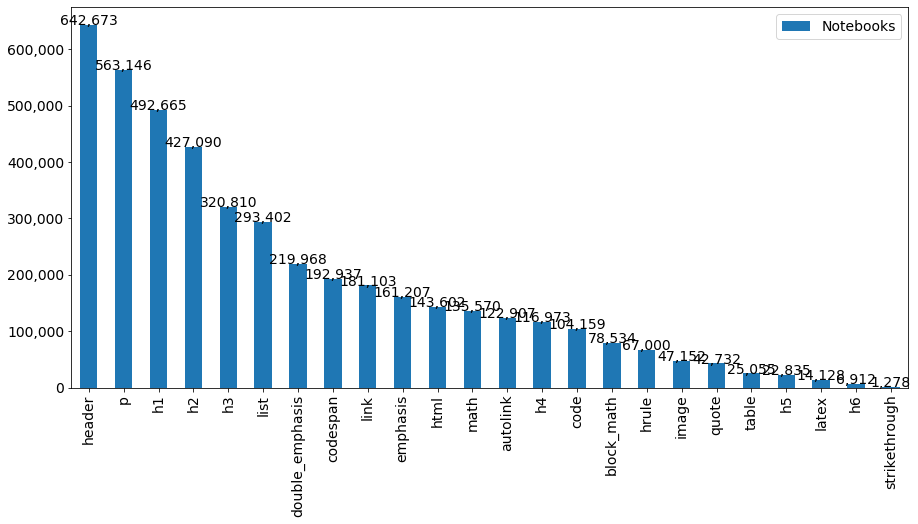

,Notebooks
header,642673
p,563146
h1,492665
h2,427090
h3,320810
list,293402
double_emphasis,219968
codespan,192937
link,181103
emphasis,161207


<Figure size 576x432 with 0 Axes>

(Sample) 


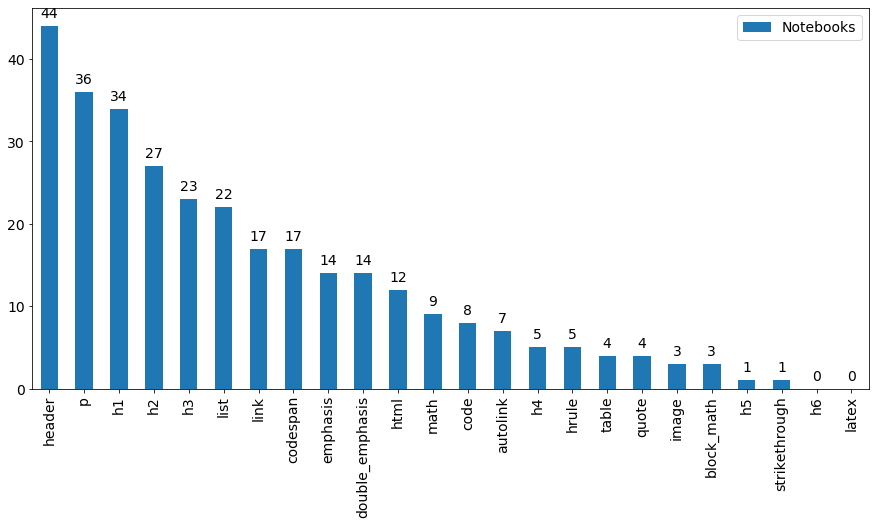

,Notebooks
header,44
p,36
h1,34
h2,27
h3,23
list,22
link,17
codespan,17
emphasis,14
double_emphasis,14


<Figure size 576x432 with 0 Axes>

(Popular) 


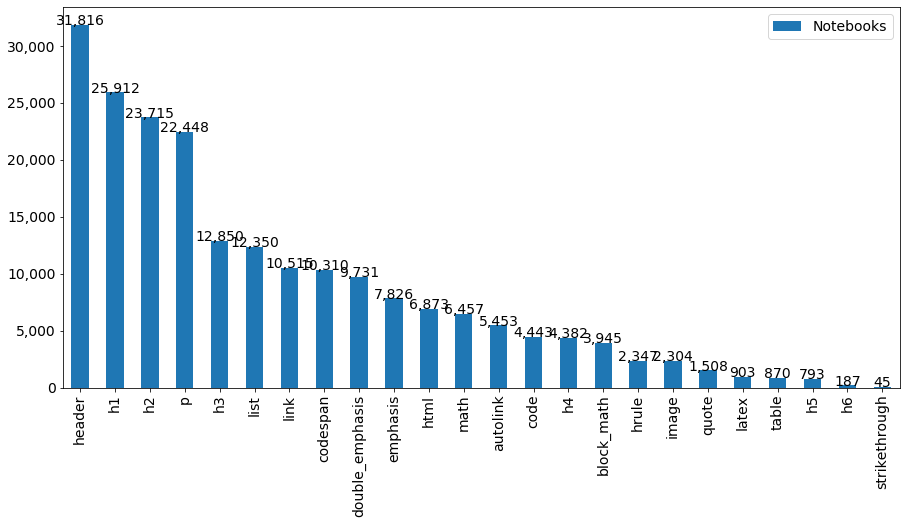

,Notebooks
header,31816
h1,25912
h2,23715
p,22448
h3,12850
list,12350
link,10515
codespan,10310
double_emphasis,9731
emphasis,7826


<Figure size 576x432 with 0 Axes>

In [20]:
def markdown_elements(counter, prefix):
    with fig(prefix + "a2_markdown_elements"):
        counter_hist(
            counter, 
            label="Notebooks",
            width=15,
            show_values=True,
            template="{:,}",
            template2="{:,.0f}",
            logy=False
        )
group_run(counters, DBMT, markdown_elements);

##### Header size


Distribution(min=0, q1=6.0, median=18.0, q3=45.0, max=4382)
Median of words in all header cells of notebooks: 18


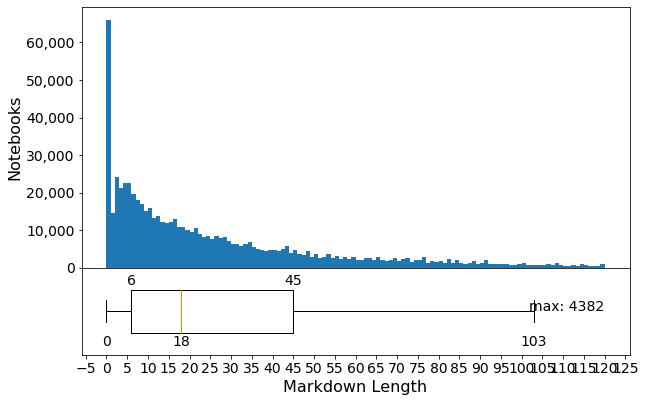

(Sample) 
Distribution(min=0, q1=7.0, median=20.0, q3=48.5, max=251)
Median of words in all header cells of notebooks: 20


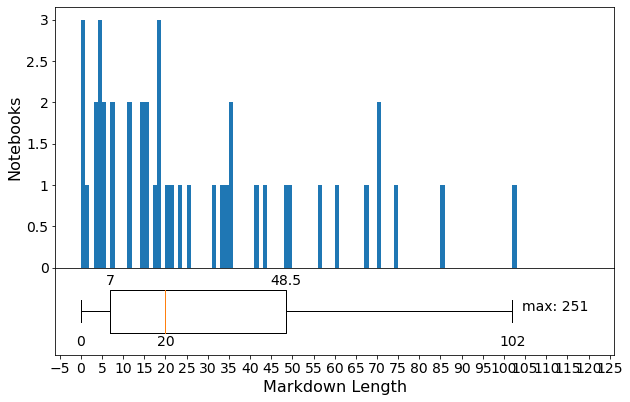

(Popular) 
Distribution(min=0, q1=9.0, median=22.0, q3=45.0, max=4361)
Median of words in all header cells of notebooks: 22


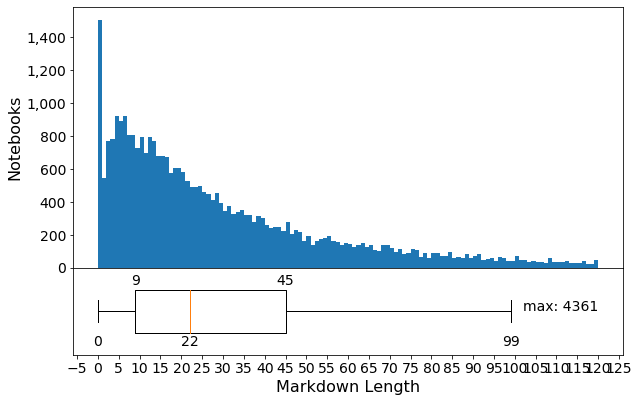

In [21]:
def markdown_header(markdowns, prefix):
    with fig(prefix + "a2_markdown_header"):
        column = markdowns["header_words"]
        distribution = distribution_with_boxplot(column, 0, 120, 5, "Notebooks", "Markdown Length",  True)
        print(distribution)
        print("Median of words in all header cells of notebooks:", 
            var(prefix + "a2_markdown_header_words_median", int(distribution.median))
        )
group_run(dbmt(markdowns), DBMT, markdown_header);

##### P size


Distribution(min=0, q1=5.0, median=89.0, q3=443.0, max=87991)
Median of words in all p cells of notebooks: 89


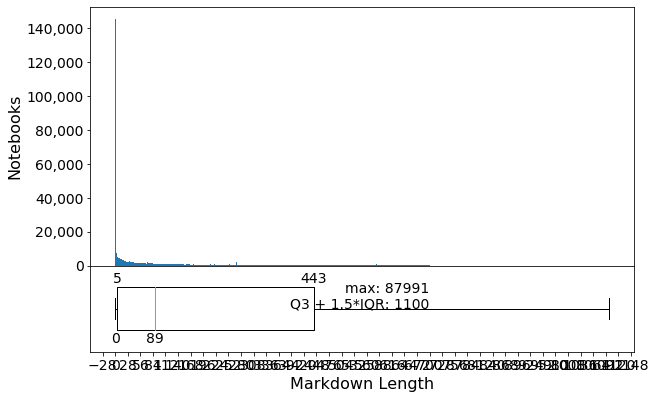

(Sample) 
Distribution(min=0, q1=1.5, median=137.0, q3=638.5, max=4929)
Median of words in all p cells of notebooks: 137


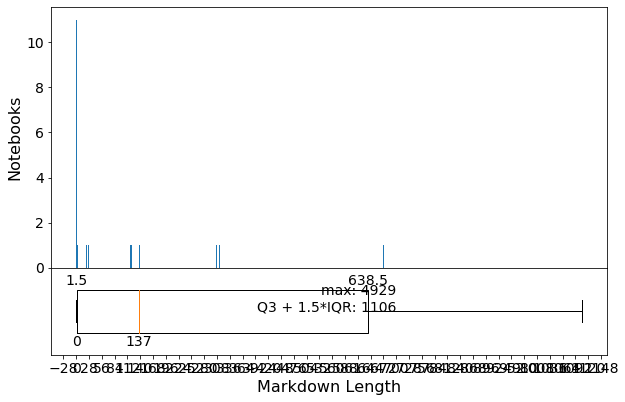

(Popular) 
Distribution(min=0, q1=0.0, median=53.0, q3=387.0, max=14294)
Median of words in all p cells of notebooks: 53


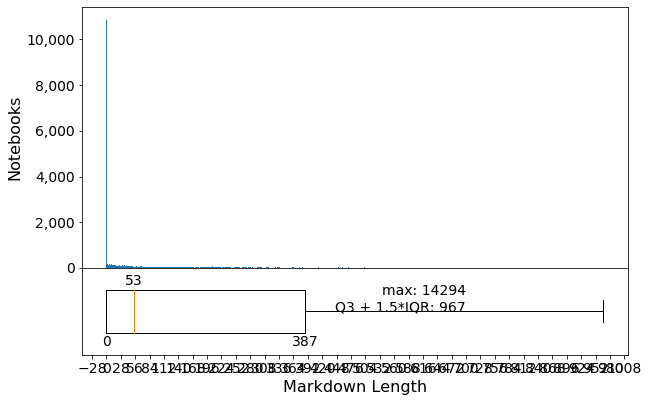

In [22]:
def markdown_words(markdowns, prefix):
    with fig(prefix + "a2_markdown_words"):
        column = markdowns["p_words"]
        distribution = distribution_with_boxplot(column, 0, 700, 28, "Notebooks", "Markdown Length",  True)
        print(distribution)
        print("Median of words in all p cells of notebooks:",
            var(prefix + "a2_markdown_p_words_median", int(distribution.median))
        )

group_run(dbmt(markdowns), DBMT, markdown_words);

## Names

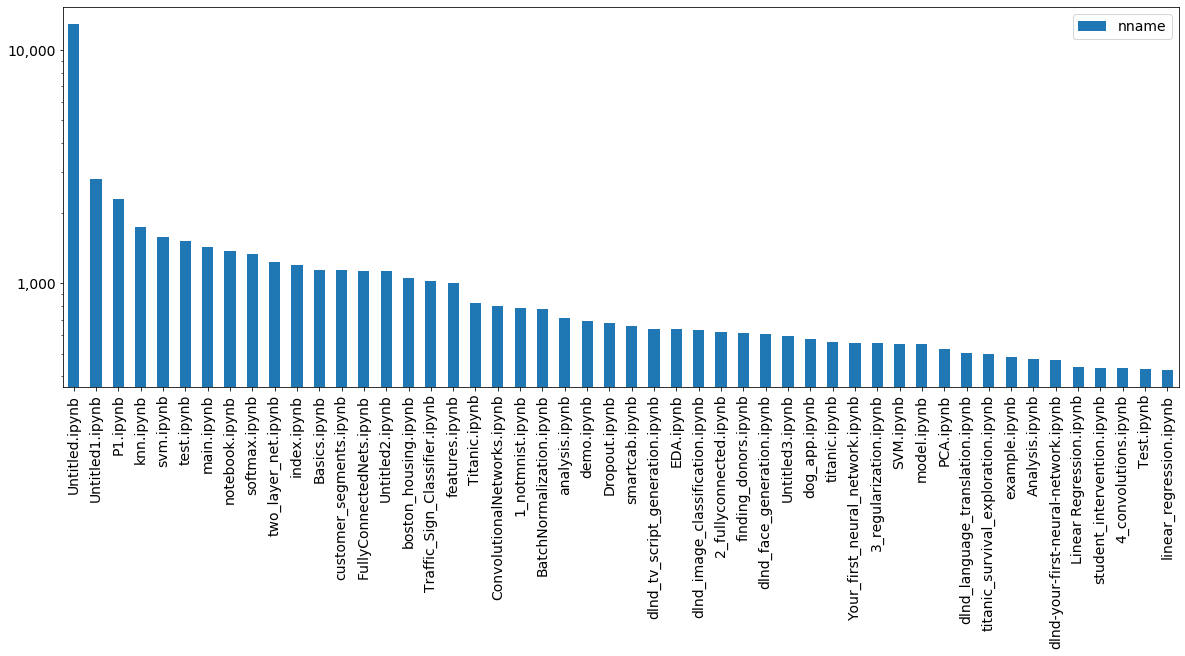

,nname
Untitled.ipynb,12939
Untitled1.ipynb,2793
P1.ipynb,2314
knn.ipynb,1740
svm.ipynb,1582
test.ipynb,1522
main.ipynb,1435
notebook.ipynb,1382
softmax.ipynb,1341
two_layer_net.ipynb,1236


<Figure size 576x432 with 0 Axes>

(Sample) 


/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 22825 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26597 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35810 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 31243 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/joao/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: Runtim

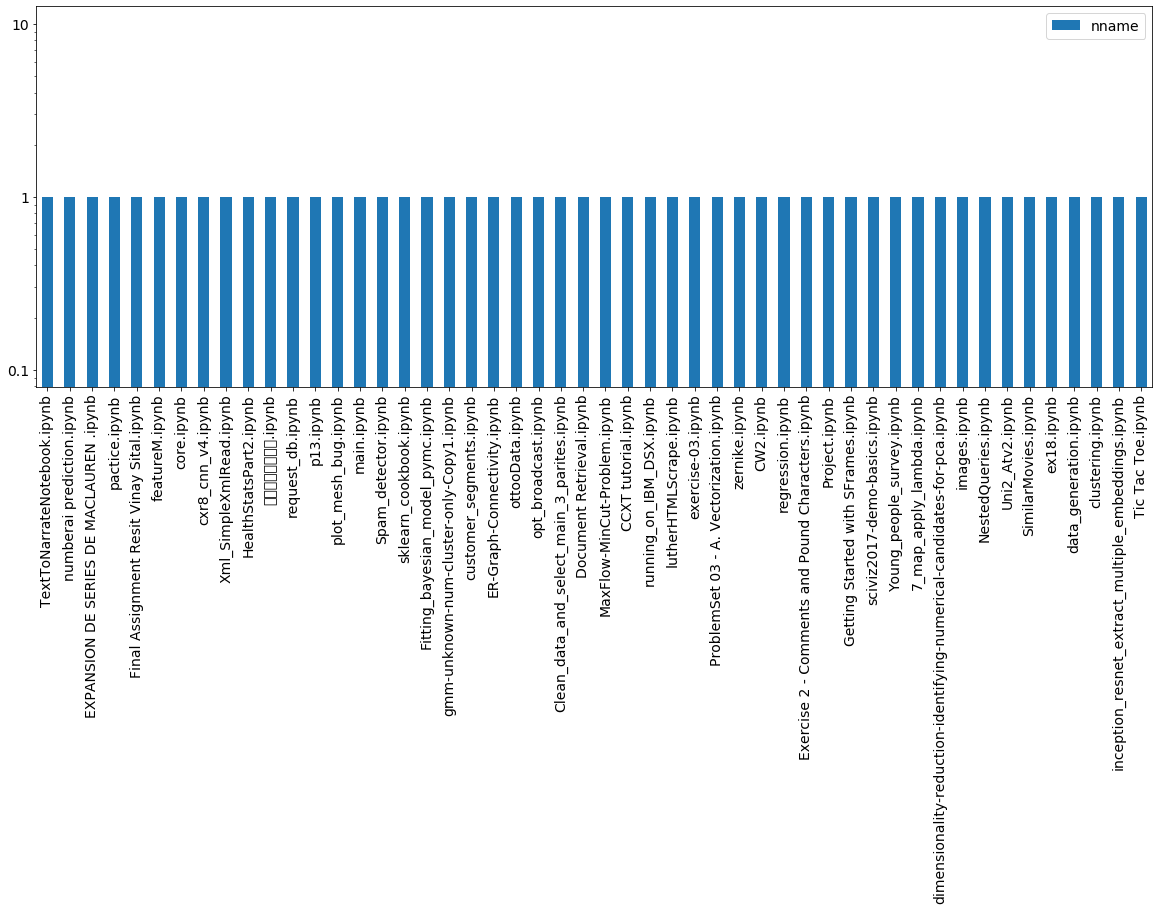

,nname
TextToNarrateNotebook.ipynb,1
numberai prediction.ipynb,1
EXPANSION DE SERIES DE MACLAUREN .ipynb,1
pactice.ipynb,1
Final Assignment Resit Vinay Sital.ipynb,1
featureM.ipynb,1
core.ipynb,1
cxr8_cnn_v4.ipynb,1
Xml_SimpleXmlRead.ipynb,1
HealthStatsPart2.ipynb,1


<Figure size 576x432 with 0 Axes>

(Popular) 


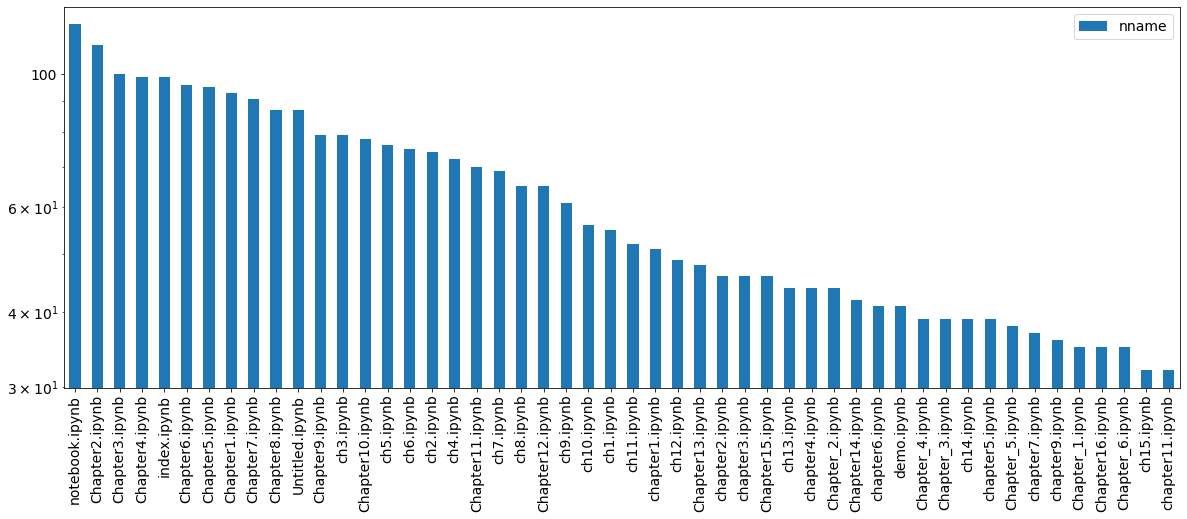

,nname
notebook.ipynb,121
Chapter2.ipynb,112
Chapter3.ipynb,100
Chapter4.ipynb,99
index.ipynb,99
Chapter6.ipynb,96
Chapter5.ipynb,95
Chapter1.ipynb,93
Chapter7.ipynb,91
Chapter8.ipynb,87


<Figure size 576x432 with 0 Axes>

In [23]:
notebooks.loc[:, "nname"] = notebook_name = notebooks["name"].str.split("/").str[-1]

def names(notebooks, prefix):
    with fig(prefix + "a2_names"):
        display_counts(notebooks["nname"].value_counts(), show_values=False, cut=slice(None, 50))

group_run(dbmt(notebooks), DBMT, names);


### Untitled

In [24]:
untitled_notebooks = notebooks[notebooks["nname"].str.startswith("Untitled")]
dbmt_relative_var(
    "{} untitled notebooks", "a2_untitled_notebooks",
    dbmt(untitled_notebooks), dbmt(notebooks),
)

a2_untitled_notebooks untitled notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"19,755 (1.93%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-1.93%
2,(Popular),td_,153 (0.40%),0.77%,0.01%,20.84%,(-) 79.16%,-1.53%


In [25]:
total_untitled = len(untitled_notebooks)

In [26]:
def more_than_two_repositories(untitled_notebooks):
    g = untitled_notebooks.groupby("repository_id").count()
    return g[g["id"] >= 2]["id"].sum()


dbmt_relative_var(
    "{} notebooks belong to repositories with two or more Untitled",
    "a2_repositories_with_2_or_more_untitled",
    dbmt(untitled_notebooks), dbmt(untitled_notebooks),
    fn=more_than_two_repositories
)

a2_repositories_with_2_or_more_untitled notebooks belong to repositories with two or more Untitled


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"11,160 (56.49%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-56.49%
2,(Popular),td_,107 (69.93%),0.96%,0.54%,123.80%,(+) 23.80%,13.44%


In [27]:
untitled_in_repositories_10_or_more = untitled_notebooks[
    untitled_notebooks["repository_id"].isin(repositories_10_or_more_ids)
]

dbmt_relative_var(
    "{} Untitled notebooks belong to repositories with 10 or more",
    "a2_untitled_in_repositories_10_or_more",
    dbmt(untitled_in_repositories_10_or_more), dbmt(untitled_notebooks),
)

a2_untitled_in_repositories_10_or_more Untitled notebooks belong to repositories with 10 or more


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"10,033 (50.79%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-50.79%
2,(Popular),td_,141 (92.16%),1.41%,0.71%,181.46%,(+) 81.46%,41.37%


### Copy

In [28]:
copy_notebooks = notebooks[notebooks["nname"].str.contains("-Copy")]
total_copy = len(copy_notebooks)
dbmt_relative_var(
    "{} copy notebooks", "a2_copy_notebooks",
    dbmt(copy_notebooks), dbmt(notebooks),
)

a2_copy_notebooks copy notebooks


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"6,989 (0.68%)",None,None,None,None,None
1,(Sample),sd_,2 (2.90%),0.03%,0.00%,424.80%,(+) 324.80%,2.22%
2,(Popular),td_,57 (0.15%),0.82%,0.01%,21.95%,(-) 78.05%,-0.53%


In [29]:
def more_than_two_repositories(copy_notebooks):
    g = copy_notebooks.groupby("repository_id").count()
    return g[g["id"] >= 2]["id"].sum()

dbmt_relative_var(
    "{} notebooks belong to repositories with two or more copy",
    "a2_repositories_with_2_or_more_copy",
    dbmt(copy_notebooks), dbmt(copy_notebooks),
    fn=more_than_two_repositories
)

a2_repositories_with_2_or_more_copy notebooks belong to repositories with two or more copy


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"4,193 (59.99%)",None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-59.99%
2,(Popular),td_,36 (63.16%),0.86%,0.52%,105.27%,(+) 5.27%,3.16%


In [30]:
copy_in_repositories_10_or_more = copy_notebooks[
    copy_notebooks["repository_id"].isin(repositories_10_or_more_ids)
]
dbmt_relative_var(
    "{} Copy notebooks belong to repositories with 10 or more",
    "a2_copy_in_repositories_10_or_more",
    dbmt(copy_in_repositories_10_or_more), dbmt(copy_notebooks),
)

a2_copy_in_repositories_10_or_more Copy notebooks belong to repositories with 10 or more


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"4,577 (65.49%)",None,None,None,None,None
1,(Sample),sd_,1 (50.00%),0.02%,0.01%,76.35%,(-) 23.65%,-15.49%
2,(Popular),td_,55 (96.49%),1.20%,0.79%,147.34%,(+) 47.34%,31.00%


### Invalid Names

In [31]:
allowed = set(ascii_letters + digits + ".-_")
invalid_names = notebooks[notebooks["nname"].apply(lambda x: bool(set(x) - allowed))]
total_invalid = len(invalid_names)

dbmt_relative_var(
    "{} invalid names", "a2_not_recommended_names",
    dbmt(invalid_names), dbmt(notebooks),
)

a2_not_recommended_names invalid names


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,"275,093 (26.86%)",None,None,None,None,None
1,(Sample),sd_,13 (18.84%),0.00%,0.00%,70.15%,(-) 29.85%,-8.02%
2,(Popular),td_,"7,809 (20.52%)",2.84%,0.76%,76.39%,(-) 23.61%,-6.34%


In [32]:
disallowed = set("<>:\"/\\|?*")
disallowed_names = notebooks[notebooks["nname"].apply(lambda x: bool(disallowed & set(x)))]
total_disallowed = len(disallowed_names)
dbmt_relative_var(
    "{} disallowed in windows", "a2_invalid_windows",
    dbmt(disallowed_names), dbmt(notebooks),
)

a2_invalid_windows disallowed in windows


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,826 (0.08%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.08%
2,(Popular),td_,11 (0.03%),1.33%,0.00%,35.84%,(-) 64.16%,-0.05%


In [33]:
dbmt_relative_var(
    "Just extension: {}", "a2_just_extension",
    dbmt(notebooks[notebook_name==".ipynb"]), dbmt(notebooks),
)

Just extension: a2_just_extension


,name,prefix,value,perc_,sup_,times_,timesone_,diff_
0,,d_,8 (0.00%),None,None,None,None,None
1,(Sample),sd_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.00%
2,(Popular),td_,0 (0.00%),0.00%,0.00%,0.00%,(-) 100.00%,-0.00%


Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


Distribution(min=0, q1=10.0, median=16.0, q3=24.0, max=187)
Median 16
Max 187


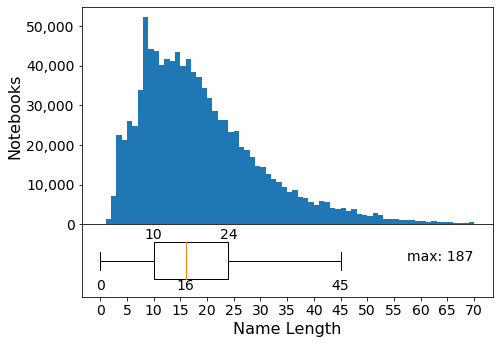

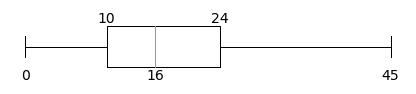

(Sample) 
Distribution(min=3, q1=10.0, median=16.0, q3=22.0, max=65)
Median 16
Max 65


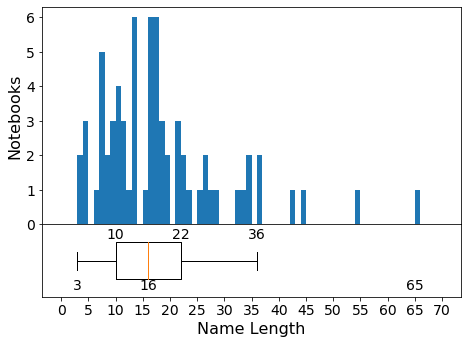

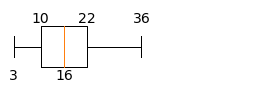

(Popular) 
Distribution(min=1, q1=9.0, median=16.0, q3=25.0, max=156)
Median 16
Max 156


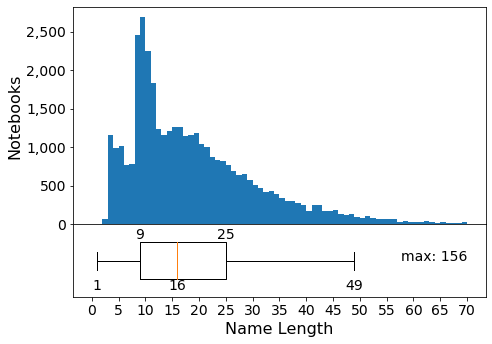

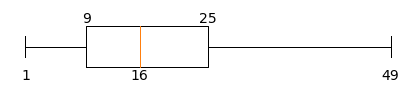

In [34]:
def name_length(notebooks, prefix):
    column = notebooks["nname"].str.len() - 6
    with savefig(prefix + "a2_notebook_name_length_full", 6, 5):
        distribution = distribution_with_boxplot(column, 0, 70, 5, "Notebooks", "Name Length",  True)
        print(distribution)
        print("Median", var(prefix + "a2_title_median", distribution.median, "{:g}"))
        print("Max", var(prefix + "a2_title_max", distribution.max, "{:g}"))
    fig = plt.gcf()
    display(fig)
    plt.close(fig)
    with savefig(prefix + "a2_notebook_name_length", 6, 1.25):
        boxplot_distribution(column, 0, 70, 5, "Notebooks", "Name Length",  True)
        
group_run(dbmt(notebooks), DBMT, name_length);

This notebook analyzed general characteristics of notebooks and markdowns to answer RQ1, RQ2 for the paper. There are other analyses that did no make into the paper. For those, refer to E1.Notebooks and E3.Markdown.